In [237]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from metronome import p_func, interval_calc
import numba

In [238]:
sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

colors = sns.color_palette('hls', 10, desat = 0.8)
#colors = colors[::-1]
colors.pop(2)

sns.set_palette(colors)

#sns.palplot(colors)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['figure.dpi'] = 150

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

In [264]:
@numba.njit
def slope_fork(x_j):
    if x_j >= 0.5:
        return 1
    else:
        return -0.59

@numba.njit
def update_x(x_j, eps, N_tot):
    x_up = x_j + (slope_fork(x_j) * eps) / N_tot
    if x_up < 1:
        return x_up
    else:
        return 1
    
@numba.njit
def met_update_x(x_j, met_eps, N_tot):
    x_up = x_j + (slope_fork(x_j) * met_eps) / N_tot
    if x_up < 1:
        return x_up
    else:
        return 1
    
@numba.njit
def clap(x, w, t, t_clap, sig):
    x = 0
    w = np.random.normal(0, sig) + 1 / (t - t_clap)
    t_clap = t
    return x, w, t_clap

@numba.njit
def p_func(n_beat, threshold_l = 16, threshold_h = 32):
    if n_beat <= threshold_l:
        p = 1
    elif n_beat > threshold_l and n_beat <= threshold_h:
        p = 1/2 * (1 + np.cos(np.pi * (n_beat - threshold_l) / (threshold_h - threshold_l + 1)))
    else:
        p = 0 
    return p

@numba.njit
def interval_calc(bpm_i, bpm_f, p):
    c_start = 60 / bpm_i
    c_end = 60 / bpm_f
    c_i = p * c_start + (1 - p) * c_end
    return c_i

def avg_calc(claps, met_claps):
    
    pt_exp = np.array(claps)
    pt_met = np.array(met_claps)


    # Calculating bin edges for time intervals to take the average of the peak times in
    bin_edges = (pt_met[:-1] + pt_met[1:])/2

    # Add start and end point
    start_diff = bin_edges[1] - bin_edges[0]
    end_diff = bin_edges[-1] - bin_edges[-2]
    bin_edges = np.pad(bin_edges, (1,1), 'constant', constant_values=(bin_edges[0] - start_diff, bin_edges[-1] + end_diff))

    fail = 0

    avg_val = []
    std_val = []
    for i in range(len(bin_edges) - 1):
        mask = (pt_exp > bin_edges[i]) & (pt_exp < bin_edges[i+1])
        masked_data = pt_exp[mask]
        if len(masked_data) > 0:
            avg = np.mean(masked_data)
            std = np.std(masked_data)
            avg_val.append(avg)
            std_val.append(std)

        else:
            fail += 1
            continue

    avg_val = np.array(avg_val)
    avg_per = avg_val[1:] - avg_val[:-1]
    avg_freq = 1/avg_per


    t_err = []
    for i in range(len(std_val)-1):
        t_err_i = np.sqrt(std_val[i]**2 + std_val[i+1]**2)
        t_err.append(t_err_i)

    freq_err = []

    for i in range(len(t_err)): 
        freq_err_i = np.sqrt(1/avg_per[i]**2 * t_err[i]**2)
        freq_err.append(freq_err_i)


    return avg_freq, freq_err, avg_per, fail #, avg_val, avg_std


def sim_with_metronome(x_init, w_init, t_clap_init, dt, tmax, freq_met=1.0, sig=0.1, eps=0.1, met_eps = 0.1, N=100):

    t = 0.1
    x = x_init.copy()
    w = w_init.copy()
    t_clap = t_clap_init.copy()
    x0_save = []
    
    w_save = [[] for i in range(N)]
    t_save = [[] for i in range(N)]
    avg_save = []
    
    x_met = 0  #metronome starts at phase 0

    for entry in range(len(w_save)):
        w_save[entry].append(w[entry])
        t_save[entry].append(t)

    while t < tmax:
        
        # metronome
        x_met += dt * freq_met
        if x_met >= 1:
            x_met = 0  # reset metronome

            # affect clappers
            for i in range(len(x)):
                x[i] = met_update_x(x[i], met_eps, N)

        x = x + w * dt

        index = np.where(x >= 1)[0] 
        
        if len(index) > 0: 
            for i in index:
                x[i] = 0  
                w[i] = np.random.normal(0, sig) + 1 / (t - t_clap[i]) 
                t_clap[i] = t
                
                w_save[i].append(w[i])
                t_save[i].append(t_clap[i])

                for j in range(len(x)):
                    if j != i:
                        x[j] = update_x(x[j], eps, N) 
                    else:
                        continue             

        t += dt
        x0_save.append(x[0])

        if int(t % (dt * 10)) == 0: 
            avg_save.append(np.mean(w))
            
    return w_save, t_save, x0_save, avg_save


def sim_sig_metronome(x_init, w_init, t_clap_init, dt, tmax, threshold_l, threshold_h, bpm_l, bpm_h, sig=0.1, eps=0.1, met_eps = 0.1, N=100):

    t = 0.1
    x = x_init.copy()
    w = w_init.copy()
    t_clap = t_clap_init.copy()
    x0_save = []
    
    w_save = [[] for i in range(N)]
    t_save = [[] for i in range(N)]

    w_met_save = []
    met_clap = []
    avg_save = []
    
    #start metronome
    x_met = 0  #metronome starts at 0
    n_beat = 0  
    p = p_func(n_beat, threshold_l, threshold_h)
    interval = interval_calc(bpm_l, bpm_h, p)
    w_met = 1 / interval
    w_met_save.append(w_met)

    for entry in range(len(w_save)):
        w_save[entry].append(w[entry])
        t_save[entry].append(t)

    while t < tmax:

        x += w * dt

        p = p_func(n_beat, threshold_l, threshold_h)
        interval = interval_calc(bpm_l, bpm_h, p)
        w_met = 1 / interval
        w_met_save.append(w_met)
        x_met += dt * w_met

        if x_met >= 1:
            x_met = 0  # reset metronome
            n_beat += 1
            met_clap.append(t)

            met_eps_n = met_eps*adjust_eps_func(n_beat, bpm_l, bpm_h)
            print(met_eps_n)

            # affect clappers
            for i in range(len(x)):
                x[i] = met_update_x(x[i], met_eps_n, N)

        index = np.where(x >= 1)[0] 
        
        if len(index) > 0: 
            for i in index:
                x[i] = 0  
                w[i] = np.random.normal(0, sig) + 1 / (t - t_clap[i]) 
                t_clap[i] = t
                
                w_save[i].append(w[i])
                t_save[i].append(t_clap[i])

                eps_n = eps * adjust_eps_func(n_beat, bpm_l, bpm_h)
                #print(eps_n)
                for j in range(len(x)):
                    if j != i:
                        x[j] = update_x(x[j], eps_n, N) 
                    else:
                        continue             

        t += dt
        x0_save.append(x[0])

        if int(t % (dt * 10)) == 0: 
            avg_save.append(np.mean(w))

            
    return w_save, t_save, x0_save, avg_save, w_met_save, met_clap

def adjust_eps_func(n_beat, bpm_l, bpm_h, threshold_l = 24, threshold_h = 40):

    if n_beat <= threshold_l:
        eps_adj = 1
    
    elif threshold_l + 1 < n_beat <= threshold_h - 1:
        C_start = 60 / bpm_l
        C_goal = 60 / bpm_h

        p_i = 0.5 * (1 + np.cos(np.pi * (n_beat - threshold_l) / (threshold_h - threshold_l)))
        C_i = p_i * C_start + (1 - p_i) * C_goal
        dC_di = - (np.pi / 34) * np.sin(np.pi * (n_beat - threshold_l) / (threshold_h - threshold_l)) * (C_start - C_goal)
        
        dw_di = -1/C_i**2 * dC_di
        
        eps_adj = 0.01/dw_di
    else:
        eps_adj = 1
    return eps_adj


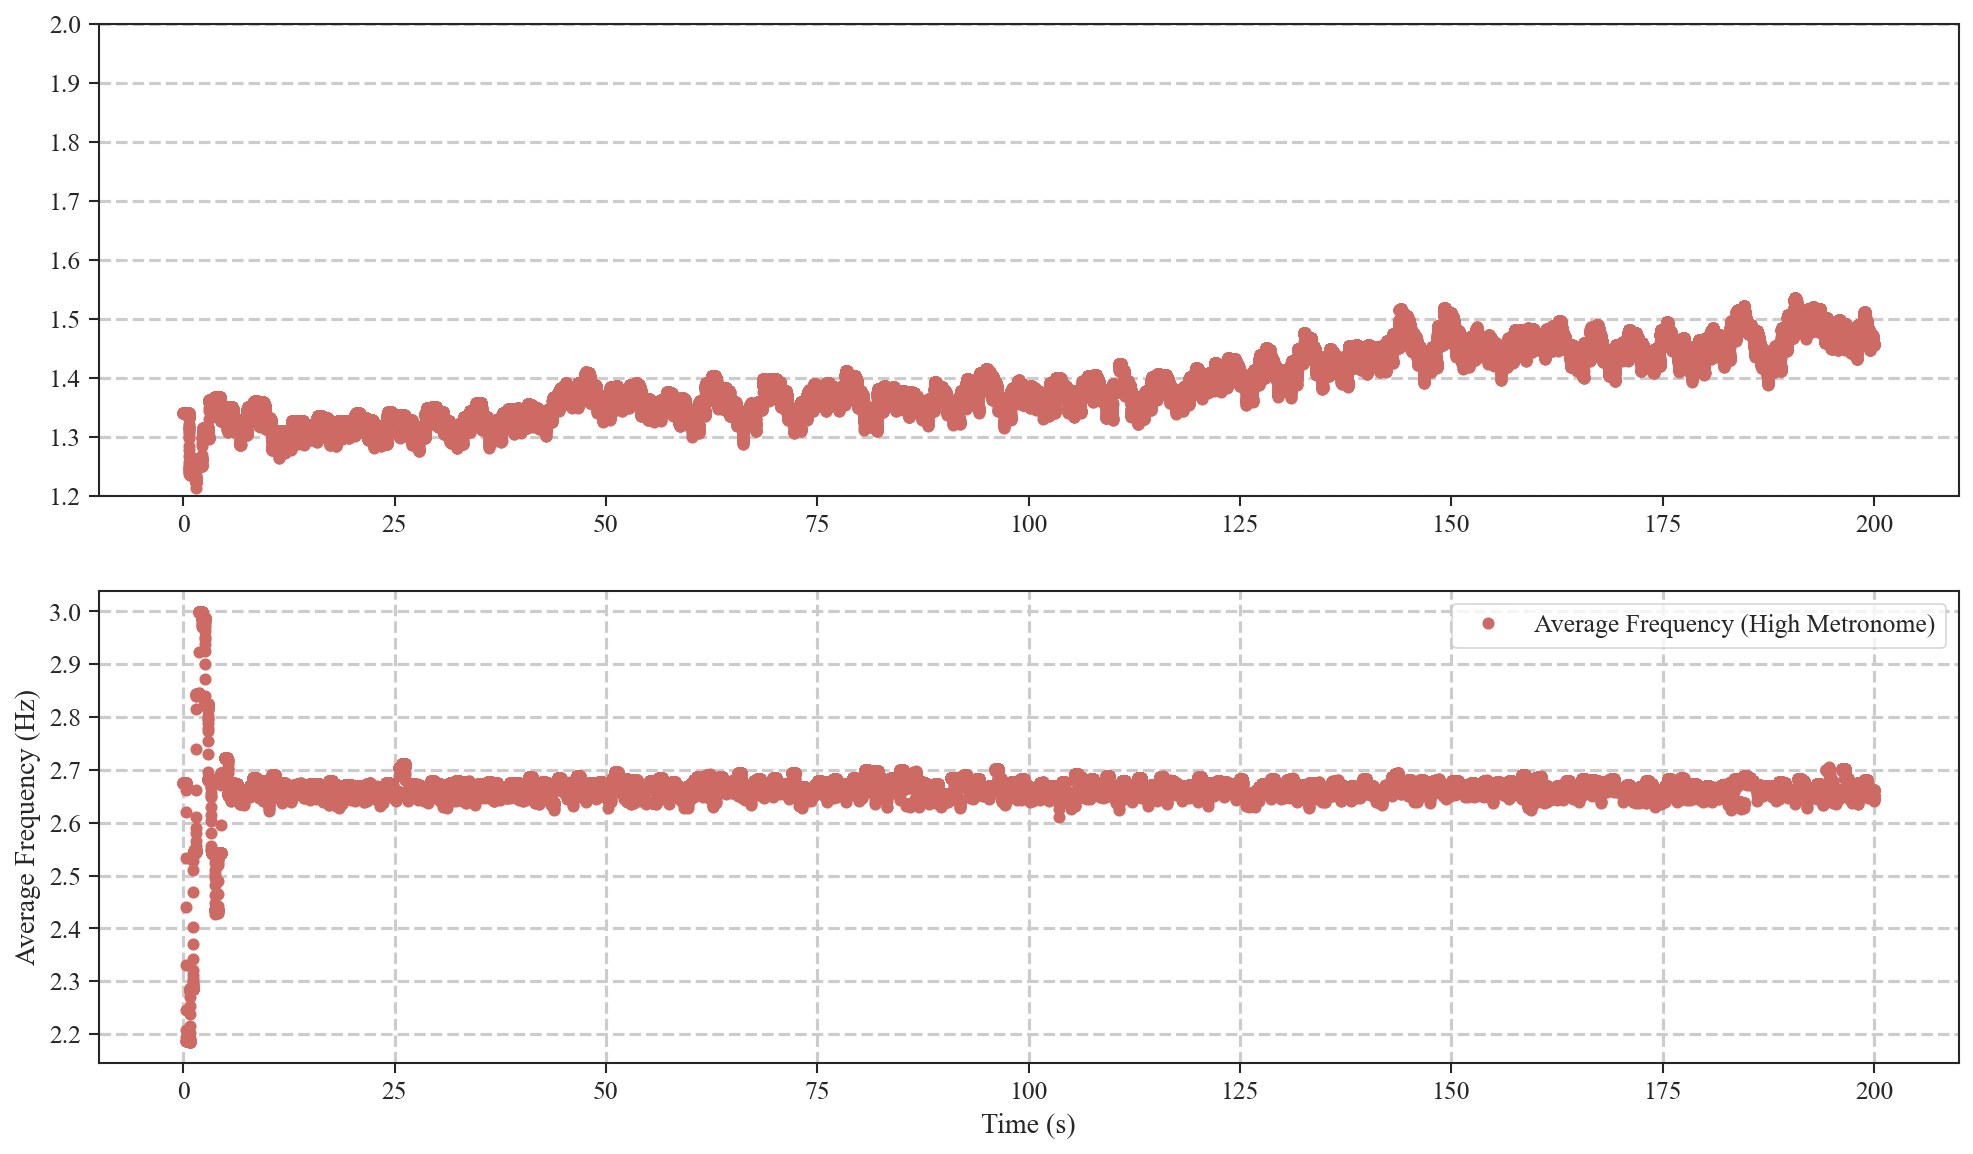

In [265]:
N = 100
w_init = np.random.normal(1.33, 0.1, N)
w_init_high = np.random.normal(2.667, 0.1, N)

x_init = np.zeros(N)
t_clap_init = np.zeros(N)

dt = 0.0025
tmax = 200


w_save, t_save, x0_save, avg_save = sim_with_metronome(x_init, 
                                                       w_init, 
                                                       t_clap_init, 
                                                       dt, 
                                                       tmax, freq_met = 1.33, 
                                                       sig=0.1, 
                                                       eps=0.1, 
                                                       met_eps = 10,
                                                       N=N)


w_save_high, t_save_high, x0_save_high, avg_save_high = sim_with_metronome(x_init, 
                                                                           w_init_high, 
                                                                           t_clap_init, 
                                                                           dt, 
                                                                           tmax, 
                                                                           freq_met = 2.667, 
                                                                           sig=0.1, 
                                                                           eps=0.1, 
                                                                           met_eps = 10,
                                                                           N=N)
                                                                           

# plotting
x1 = np.linspace(0, tmax, len(avg_save))
x1_high = np.linspace(0, tmax, len(avg_save_high))

fig, ax = plt.subplots(2, 1, dpi=150)
ax[0].plot(x1, avg_save, 'o', label='Average Frequency')
ax[0].set_ylim(1.2,2)

ax[1].plot(x1_high, avg_save_high, 'o', label='Average Frequency (High Metronome)')

plt.xlabel('Time (s)')
plt.ylabel('Average Frequency (Hz)')
#
plt.legend()
plt.grid(True)
plt.show()

In [269]:
N=5
w_init = np.random.normal(1.33, 0.1, N)
x_init = np.zeros(N)
t_clap_init = np.zeros(N)
dt = 0.01



tmax = 35 
threshold_l = 24
threshold_h = 40
bpm_l = 80
bpm_h = 160


w_sig_save, t_sig_save, x0_sig_save, avg_sig_save, w_met_sig_save, met_clap = sim_sig_metronome(x_init,
                                                                                        w_init, 
                                                                                        t_clap_init, 
                                                                                        dt, 
                                                                                        tmax, 
                                                                                        threshold_l, 
                                                                                        threshold_h, 
                                                                                        bpm_l, 
                                                                                        bpm_h, 
                                                                                        sig=0.1, 
                                                                                        eps=0.1, 
                                                                                        met_eps=0.6,
                                                                                        N=N)

0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.24493071016838985
0.16085826255405714
0.11831416978548706
0.09256007817765192
0.07539784582138363
0.06336419346059413
0.05478908915938498
0.048833223552236224
0.04513866742153565
0.04374821288784276
0.045262050906307125
0.05152804046455204
0.06856729401018193
0.12722745871410338
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6
0.6


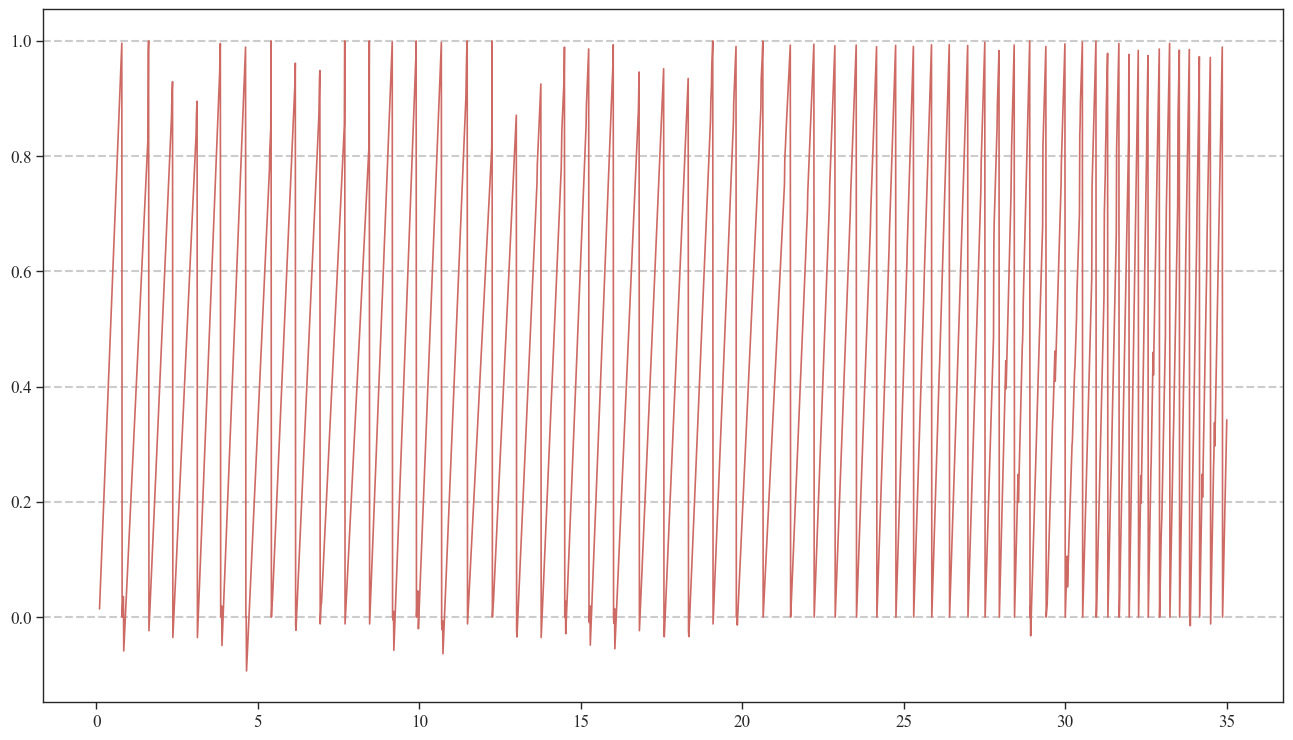

In [270]:

fig_x0, ax_x0 = plt.subplots(dpi=100)

t_linspace = np.linspace(0.1, tmax, len(x0_sig_save))
ax_x0.plot(t_linspace, x0_sig_save, label='Clapper 0')

5
58 57
0


Text(0.05, 0.9, 'Deviation Sum: 0.31')

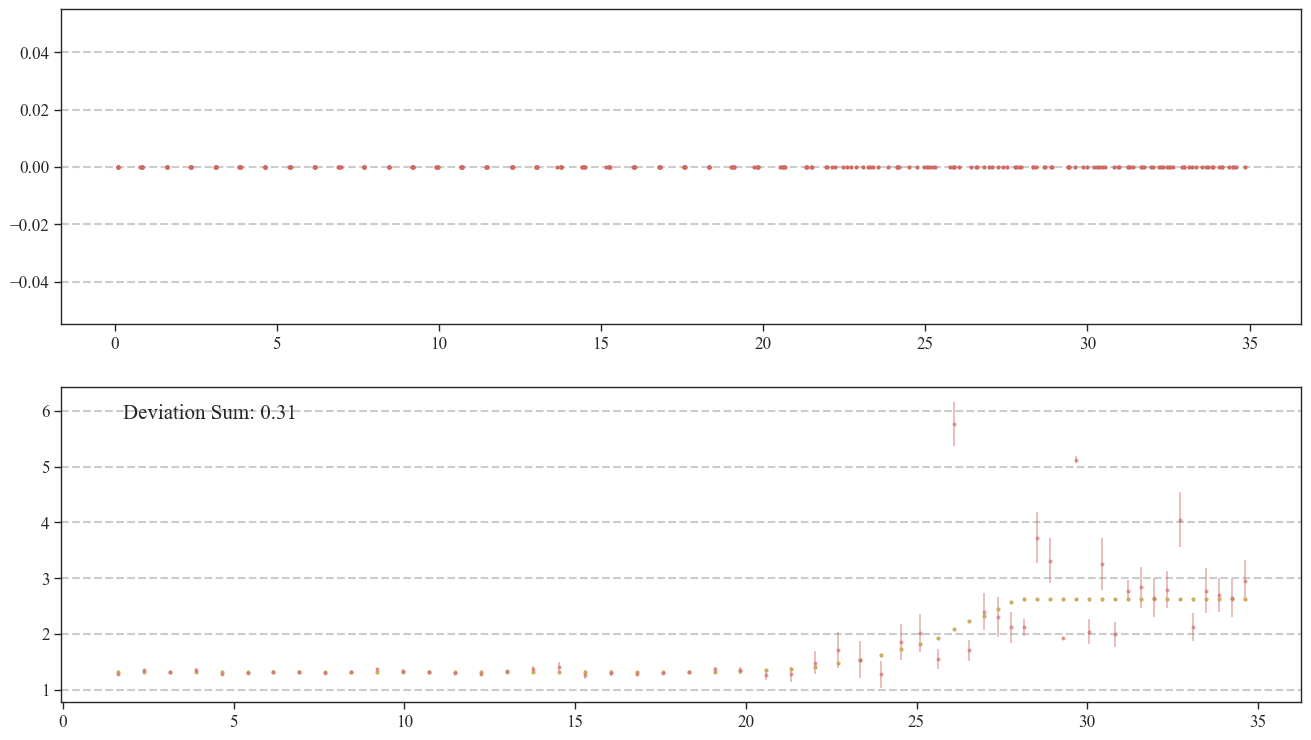

In [271]:
t_clap_comb = np.concatenate(t_sig_save)
print(len(t_sig_save))
avg_freq, freq_err, avg_per, fail = avg_calc(t_clap_comb, met_clap)
print(len(met_clap), len(avg_freq))

print(fail)

fig, ax = plt.subplots(2,1, dpi=100)
ax[0].plot(t_clap_comb, np.zeros(len(t_clap_comb)), 'o', label='Clap Times', markersize = 2)
#ax[0].plot(met_clap, np.zeros(len(met_clap)), 'o', label='Metronome Clap Times')


met_freq = 1 / np.diff(met_clap)
deviation = np.abs(avg_freq - met_freq)
dev_mean = np.mean(deviation)

ax[1].errorbar(met_clap[1:], avg_freq, yerr=freq_err, fmt='o', label='Average Frequency', alpha=0.5, markersize = 2)
ax[1].plot(met_clap[1:], met_freq, 'o', label='Metronome Frequency', markersize = 2)
ax[1].text(0.05, 0.9, 'Deviation Sum: {:.2f}'.format(dev_mean), transform=ax[1].transAxes, fontsize=15)


In [228]:
from tqdm import tqdm

ModuleNotFoundError: No module named 'tqdm'

In [78]:

def parameter_search(N=100, sig=0.1, eps=0.1, met_eps=10, start_bpm=60, end_bpm=120):
    
    t_clap_list = []
    met_clap_list = []

    for i in tqdm(sig, desc='sigma iteration', unit='iteration'):
        sig_save = []
        sig_save_met = []
        for j in eps:
            eps_save = []
            eps_save_met =[]
            for k in met_eps:
                met_eps_save = []
                met_eps_save_met = []

                for l in N:

                    # Defining usual parameters
                    w_init = np.random.normal( start_bpm / 60 , 0.1, l )
                    x_init = np.zeros(l)
                    t_clap_init = np.zeros(l)
                    dt = 0.0025
                    tmax = 40
                    threshold_l = 24
                    threshold_h = 40


                    w_save, t_save, x0_save, avg_save, w_met_save, met_clap = sim_sig_metronome(x_init, 
                                                                                      w_init, 
                                                                                      t_clap_init, 
                                                                                      dt, 
                                                                                      tmax, 
                                                                                      threshold_l, 
                                                                                      threshold_h, 
                                                                                      start_bpm, 
                                                                                      end_bpm, 
                                                                                      sig=i, 
                                                                                      eps=j, 
                                                                                      met_eps=k,
                                                                                      N=l)
                    t_clap_comb = np.concatenate(t_save)
                    avg_freq, freq_err, avg_per, fail = avg_calc(t_clap_comb, met_clap)
                    
                    #print(len(avg_freq), len(met_clap), '\nFails:', fail)



                    deviation = abs(avg_freq - met_clap[:1])
                    dev_mean = np.mean(deviation)


                    met_eps_save.append(avg_freq)
                    met_eps_save_met.append(met_clap)

                eps_save.append(met_eps_save)
                eps_save_met.append(met_eps_save_met)

            sig_save.append(eps_save)
            sig_save_met.append(eps_save_met)

        t_clap_list.append(sig_save)
        met_clap_list.append(sig_save_met)

    return t_clap_list, met_clap_list

        

N = np.arange(30, 100, 10)
sig=[0.05, 0.1, 0.15]
eps=[0.05, 0.1, 0.15]
met_eps=[5, 10, 15]


t_clap_list, met_clap_list = parameter_search(N=N, sig=sig, eps=eps, met_eps=met_eps, start_bpm=60, end_bpm=120)




NameError: name 'tqdm' is not defined